# Climate Markov and Prediction
Predict temperature change with nth-order Markov probability model.
This model is highly under-optimized, and is very slow when using large datasets.
The phenomenom of removing high volabilities makes multistep prediction with only
this model unrealistic.

This model has the following assumptions:
 - Past temperatures in the same time of the year change alike.
 - All places change alike.
 - Temperature change is only dependent on the time of the year and the
      previous few temperature.

Global TODO:
 - Add support for hemisphere detection (currently all dataset input should
   be in the same hemisphere.
 - Add Gaussian for location of the station.
 - Return the confidence of the prediction.

In [1]:
import gsod
import numpy as np
import scipy.optimize as so
from matplotlib import pyplot as plt
from numpy.typing import NDArray

gsod.enable_svg_graphing()

Specification for datasets.

In [2]:
STATION = "583620"
ds = gsod.GsodDataset("runtime/GSOD")
df = ds.read_continuous(stn=STATION, year="2020", interpolate=True)["TEMP"]

From now on, we will start using Cython to speed things up.

In [3]:
!python setup.py build_ext --inplace
from climate2 import NDTemperaturePredict

running build_ext
copying build/lib.macosx-11.0-arm64-3.9/climate2.cpython-39-darwin.so -> 


Distance matrix:

In [4]:
# Initialize predictors
model = NDTemperaturePredict()
temperatures = df.to_numpy()
dates = np.fromiter((date - date.astype("datetime64[Y]") for date in df.index.to_numpy()), "timedelta64[D]", count=len(temperatures))
model.put_data(temperatures, dates.astype(int))

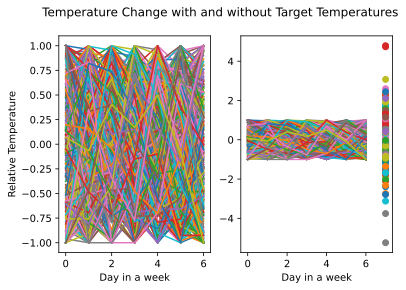

In [5]:
plt.suptitle("Temperature Change with and without Target Temperatures")
plt.subplot(1, 2, 1)
plt.xlabel("Day in a week")
plt.ylabel("Relative Temperature")
for s in model.normalized_degree_wise(temperatures):
    plt.plot(s[:-1])

plt.subplot(1, 2, 2)
plt.xlabel("Day in a week")
# No need for duplicated label
# plt.ylabel("Relative temperature")
for s in model.normalized_degree_wise(temperatures):
    plt.plot(s[:-1])
    plt.scatter(7, s[-1])

In [6]:
# Yields a lower triangle matrix
itms = np.array(list(model.normalized_degree_wise(temperatures)))
distance_matrix = np.zeros((len(itms), len(itms)))

for x,l1 in enumerate(itms):
    for y,l2 in enumerate(itms):
        distance_matrix[x][y] = model.distance(l1[:-1], l2[:-1])
distance_matrix = np.tril(distance_matrix)
distance_matrix

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.41185334, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.73140086, 0.32393095, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.46800813, 0.80826003, 1.12019783, ..., 0.        , 0.        ,
        0.        ],
       [0.38986345, 0.45462365, 0.65891343, ..., 1.34756708, 0.        ,
        0.        ],
       [0.39920946, 0.10154068, 0.23471543, ..., 0.94680007, 0.47967551,
        0.        ]])

The pair with minimum distance, see the result:

In [7]:
mindist = np.argmin(np.ma.masked_equal(distance_matrix, 0.0, copy=False))
xmin = mindist // distance_matrix.shape[0]
ymin = mindist % distance_matrix.shape[1]
distance_matrix[xmin][ymin], xmin, ymin

(0.004610636456020195, 129, 38)

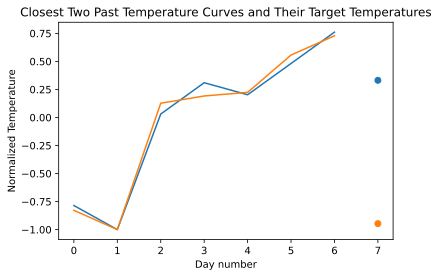

In [8]:
plt.xlabel("Day number")
plt.ylabel("Normalized Temperature")
plt.title("Closest Two Past Temperature Curves and Their Target Temperatures")
plt.plot(itms[xmin][:-1])
plt.plot(itms[ymin][:-1])
plt.scatter(7, itms[xmin][-1])
plt.scatter(7, itms[ymin][-1])

Pretty close, huh? Try some LOOCV:

In [9]:
model.loocv_loss()

1.1321608022312308

Oops, high error. But the best case is almost correct.
Can we do some gradient descent to optimise the weights?

In [10]:
# Initial guess from information gain.
model.set_weights(np.array([0.04099494, 0.05690496, 0.06560248, 0.04932428, 0.02320112, 0.03939494, 0.29684948]))

In [11]:
with np.printoptions(precision=4):
    model.train()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27734D+00    |proj g|=  2.49030D-01
Current loss: 1.1388391482547051, weights: [0.3207 0.2817 0.3023 0.2866 0.2082 0.2971 0.3312]
At iterate    1    f=  1.13884D+00    |proj g|=  1.61778D-01
Current loss: 1.0337865633668062, weights: [ 0.4596  0.3862  0.4371  0.41    0.2838  0.4533 -0.2192]
At iterate    2    f=  1.03379D+00    |proj g|=  1.90260D-01
Current loss: 1.0079720375072656, weights: [ 1.      1.      1.      1.      0.7024  1.     -1.    ]
At iterate    3    f=  1.00797D+00    |proj g|=  7.93831D-02
Current loss: 1.006849506479307, weights: [ 1.      1.      1.      1.      0.7274  1.     -0.8968]
At iterate    4    f=  1.00685D+00    |proj g|=  3.57220D-02
Current loss: 1.0059429857039905, weights: [ 0.9931  0.9971  1.      0.9947  0.7237  0.9953 -0.9253]
At iterate    5    f=  1.00594

In [12]:
model.loocv_loss()

0.9550023804125034

In [13]:
model.predict(
    np.array([81.02357483, 81.02357483, 81.02357483, 81.02357483, 81.02357483, 81.02357483,
 81.02357483]),
    np.timedelta64(262)
)

81.02357483000002

In [14]:
def next_tmp(model, initial_tmps: NDArray, initial_date: int):
    prevs = initial_tmps
    date = initial_date
    while True:
        now = model.predict(
            prevs,
            np.timedelta64(date)
        )
        prevs[:-1] = prevs[1:]
        prevs[-1] = now
        date += 1
        date %= 365
        yield now
seq = next_tmp(model, np.array([30,29,29,26,26,25,26]) * 1.8 + 32, 202)

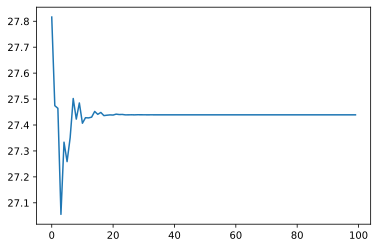

In [15]:
plt.plot([(next(seq) - 32) / 1.8 for i in range(100)])